<a href="https://colab.research.google.com/github/aayush2710/CTW2020-IDP/blob/master/CNN_mimo_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/CTW_2019"

best_cnn.h5			  data_feat.h5
CTW2019_Dataset_h5.zip		  h_Estimated_CTW_Train.h5
CTW2019_logarithimic_mean_sqr.h5  r_Position_CTW_Train.h5
CTW2019_mean_sqr2.h5		  SNR_CTW_Train.h5
CTW2019_mean_sqr.h5		  test.out
data2019.h5


In [ ]:
import numpy as np # linear algebra
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, ReLU, Input, Dropout, Conv2D, AveragePooling2D, Flatten, AveragePooling1D
from keras.optimizers import RMSprop
import numpy as np
import os
import h5py
import pandas as pd
import time
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
f = h5py.File('/content/gdrive/My Drive/CTW_2019/h_Estimated_CTW_Train.h5','r')
print(H_re.shape)
H = f['h_Estimated']

(924, 16, 17486)


In [ ]:
f = h5py.File('/content/gdrive/My Drive/CTW_2019/r_Position_CTW_Train.h5','r')
pos = f['r_Position']
f = h5py.File('/content/gdrive/My Drive/CTW_2019/SNR_CTW_Train.h5','r')
SNR = f['SNR_Est']

In [ ]:
print(H.shape)
H = np.array(H)
pos = np.array(pos)
#data = H.reshape((17486,16,924,2))
#Y = pos.reshape((17486,3))

(2, 924, 16, 17486)


In [ ]:
data = H.swapaxes(0,-1)
print(data.shape)

print(data[1].shape)
print(H[1,:,:,1])

(17486, 924, 16, 2)
(924, 16, 2)
[[-0.00667697  0.00677012 -0.01512622 ... -0.00781836 -0.02160719
  -0.01629161]
 [-0.00661456  0.0078049  -0.01547601 ... -0.00319625 -0.01436212
  -0.01815782]
 [-0.00828001  0.00788109 -0.01604509 ... -0.00448148 -0.01544323
  -0.0178247 ]
 ...
 [-0.00720208  0.00833462 -0.01695996 ... -0.00704735 -0.01458594
  -0.01329758]
 [-0.00649157  0.00688685 -0.01558057 ... -0.00883849 -0.01653699
  -0.01953695]
 [-0.00863339  0.00543334 -0.01801011 ... -0.00701089 -0.01741782
  -0.01549244]]


In [ ]:
pos = pos.swapaxes(0,1)
print(pos.shape)
print(pos[1])

(17486, 3)
[ 3.878  -0.4384 -0.5266]


In [ ]:


from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)
y_train,y_test = train_test_split(pos, test_size=0.1, random_state=42, shuffle=True)
#print(H_new.shape,pos.shape)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)



(15737, 924, 16, 2) (1749, 924, 16, 2)
(15737, 3) (1749, 3)


In [ ]:
def cnn2d():
  inp = Input(shape=(924,16,2))
  x = Conv2D(32, (3,3), padding="same",activation='relu')(inp)
  x = AveragePooling2D(pool_size=(4,1))(x)
  x =Dropout(0.25)(x)
  x = Conv2D(32, (3,3), padding="same",activation='relu')(x)
  x = AveragePooling2D(pool_size=(4,1))(x)
  x = Dropout(0.25)(x)

  x = Flatten()(x)
  x = Dense(256,activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(256,activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(256,activation='relu')(x)
  x  = Dropout(0.2)(x)

  out = Dense(3)(x)

  
  return Model(inp,out)


In [ ]:
m1 = cnn2d()
print(m1.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 924, 16, 2)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 924, 16, 32)       608       
_________________________________________________________________
average_pooling2d_38 (Averag (None, 231, 16, 32)       0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 231, 16, 32)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 231, 16, 32)       9248      
_________________________________________________________________
average_pooling2d_39 (Averag (None, 57, 16, 32)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 57, 16, 32)        0   

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# move tensors to GPU if CUDA is available
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience = 20)
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/CTW_2019/best_cnn.h5', verbose=1, save_best_only=True)

opt = RMSprop(learning_rate=0.001, decay=1e-6)
m1.compile(loss='mean_squared_error',
              optimizer=opt,
              )

m1.fit(X_train, y_train,
              batch_size=20,
              epochs=1000,
              validation_split=0.12,
              shuffle=True, callbacks=[early_stopping, checkpointer])
    
'''
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)
'''
# Score trained model.
scores = m1.evaluate(X_test, y_test, verbose=1)


Train on 13848 samples, validate on 1889 samples
Epoch 1/1000
13848/13848 [==============================] - 11s 797us/step - loss: 0.3810 - val_loss: 0.3327

Epoch 00001: val_loss improved from inf to 0.33268, saving model to /content/gdrive/My Drive/CTW_2019/best_cnn.h5
Epoch 2/1000
13848/13848 [==============================] - 11s 776us/step - loss: 0.3154 - val_loss: 0.2568

Epoch 00002: val_loss improved from 0.33268 to 0.25675, saving model to /content/gdrive/My Drive/CTW_2019/best_cnn.h5
Epoch 3/1000
13848/13848 [==============================] - 11s 774us/step - loss: 0.2701 - val_loss: 0.2364

Epoch 00003: val_loss improved from 0.25675 to 0.23638, saving model to /content/gdrive/My Drive/CTW_2019/best_cnn.h5
Epoch 4/1000
13848/13848 [==============================] - 11s 774us/step - loss: 0.2360 - val_loss: 0.2623

Epoch 00004: val_loss did not improve from 0.23638
Epoch 5/1000
13848/13848 [==============================] - 11s 767us/step - loss: 0.2110 - val_loss: 0.2565



TypeError: ignored

In [ ]:

def rmse(p1, p2):
  return np.sqrt(np.sum((p1-p2)**2, axis = 1))

[[ 4.911024    1.5168836  -0.51397026]
 [ 4.3243456   0.34368864 -0.5178447 ]
 [ 4.5668516   1.0344276  -0.5170463 ]
 ...
 [ 3.8136008   1.2381073  -0.5210979 ]
 [ 5.3589334   1.8767588  -0.517688  ]
 [ 4.455924    1.4285104  -0.5176318 ]]
[[ 5.1697  1.5755 -0.5268]
 [ 5.0422  0.576  -0.5254]
 [ 4.0611  0.9462 -0.5268]
 ...
 [ 3.6799  1.0983 -0.5251]
 [ 5.6319  1.5365 -0.5226]
 [ 4.0911  0.4399 -0.5252]]


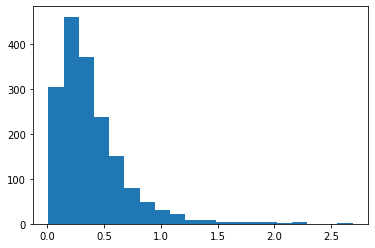

(array([  1.,   6.,   7.,   8.,   7.,  27.,  28.,  51.,  91., 119., 196.,
        213., 265., 256., 216., 134.,  70.,  32.,  14.,   8.]),
 array([-4.73741372, -4.4510891 , -4.16476447, -3.87843985, -3.59211522,
        -3.3057906 , -3.01946598, -2.73314135, -2.44681673, -2.1604921 ,
        -1.87416748, -1.58784285, -1.30151823, -1.0151936 , -0.72886898,
        -0.44254435, -0.15621973,  0.13010489,  0.41642952,  0.70275414,
         0.98907877]),
 <a list of 20 Patch objects>)

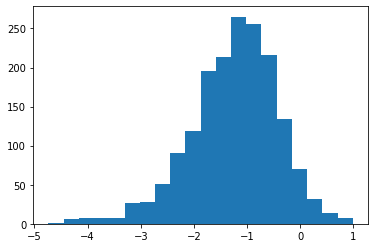

In [ ]:
m2 = load_model('/content/gdrive/My Drive/CTW_2019/best_cnn.h5')
tt = m2.predict(X_test)
print(tt)
print(y_test)
gg  = (rmse(tt,y_test))


plt.hist(gg, bins=20)
plt.show()
plt.hist(np.log(gg), bins=20)

In [ ]:
ttt = m2.predict(X_test)

dd = rmse(ttt, y_test)

print(np.mean(dd))

0.388499792952066
